# 1. Explorar las ofertas relámpago, ¿qué insights puedes generar?

## Objetivo: de este desafío es hacer un EDA sobre estos datos buscando insights sobre este tipo de ofertas.


# Sumário
1. Exploração dos dados 
2. Insights gerais  
3. Insights por Catagorias
4. Insights mais significativos (Resumo)




# 1. Exploração dos dados

In [39]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np

dtrelampago = pd.read_csv('ofertas_relampago.csv')
dtrelampago.shape

(48746, 13)

In [40]:
# convet object to Date 
dtrelampago['OFFER_START_DTTM'] = pd.to_datetime(dtrelampago['OFFER_START_DTTM'])
dtrelampago['OFFER_FINISH_DTTM'] = pd.to_datetime(dtrelampago['OFFER_FINISH_DTTM'])
dtrelampago['OFFER_START_DATE'] = pd.to_datetime(dtrelampago['OFFER_START_DATE'])

# alguns SOLD_QUANTITY são nulos 
dtrelampago.loc[dtrelampago['SOLD_QUANTITY'].isnull(), 'SOLD_QUANTITY'] = dtrelampago['INVOLVED_STOCK']  -dtrelampago['REMAINING_STOCK_AFTER_END'] 


# cria fetures adicionais 
dtrelampago['duration'] =  dtrelampago['OFFER_FINISH_DTTM'] -dtrelampago['OFFER_START_DTTM']
dtrelampago[['OFFER_START_DTTM', 'OFFER_FINISH_DTTM', 'duration']]
dtrelampago['duration']=dtrelampago['duration']/np.timedelta64(1,'h')
dtrelampago['WEEKDAY'] = dtrelampago['OFFER_START_DTTM'].dt.dayofweek
dtrelampago['START_HOUR'] = dtrelampago['OFFER_START_DTTM'].dt.hour
dtrelampago['MONTH'] = dtrelampago['OFFER_START_DTTM'].astype(int) % 12 + 1


# sales rate  = accomplished  / planned
dtrelampago['SALES_RATE'] =  (dtrelampago['INVOLVED_STOCK'] -   dtrelampago['REMAINING_STOCK_AFTER_END'])  /dtrelampago['INVOLVED_STOCK'] 


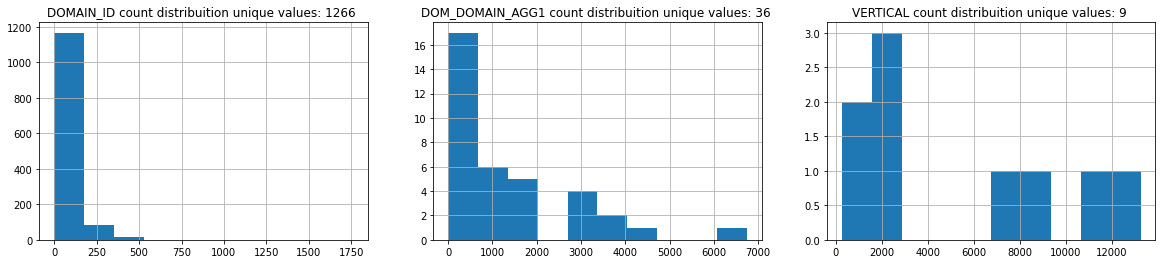

In [41]:
# Panorama dos dados catagoricos 
import matplotlib.pyplot as plt
campos = ['DOMAIN_ID', 'DOM_DOMAIN_AGG1', 'VERTICAL']

fig, axs = plt.subplots(1, len(campos), figsize=(20,4))

for i, campo in enumerate(campos):
    Dt_DOMAIN_ID = dtrelampago.groupby([campo])[campo].count().hist(ax=axs[i])
    axs[i].title.set_text('{} count distribuition unique values: {} '.format(campo , len(dtrelampago[campo].unique())) )


In [42]:

numberDOM_DOMAIN_AGG1 =  len(dtrelampago.groupby('DOM_DOMAIN_AGG1')['DOM_DOMAIN_AGG1'].count())
numberDOM_DOMAIN_AGG1_VERTICAL =  len(dtrelampago.groupby(['DOM_DOMAIN_AGG1', 'VERTICAL'])[['DOM_DOMAIN_AGG1', 'VERTICAL']].count())
print(" DOM_DOMAIN_AGG1 possui {} valores possiveis  / DOM_DOMAIN_AGG1-VERTICAL {} ".format(numberDOM_DOMAIN_AGG1,numberDOM_DOMAIN_AGG1_VERTICAL ) )
print(" DOM_DOMAIN_AGG1 é uma subcategoria de VERTICAL ")


 DOM_DOMAIN_AGG1 possui 36 valores possiveis  / DOM_DOMAIN_AGG1-VERTICAL 36 
 DOM_DOMAIN_AGG1 é uma subcategoria de VERTICAL 


In [43]:
#  Quantidade por VERTICAL
dtrelampago.groupby(['VERTICAL'])['VERTICAL'].count().sort_values()

VERTICAL
OTHERS               279
ENTERTAINMENT        525
ACC                 2573
T & B               2624
CPG                 2714
BEAUTY & HEALTH     7150
CE                  8629
HOME & INDUSTRY    11011
APP & SPORTS       13241
Name: VERTICAL, dtype: int64

In [44]:
#  DOM_DOMAIN_AGG1 mais populares 
dtrelampago.groupby(['DOM_DOMAIN_AGG1'])['DOM_DOMAIN_AGG1'].count().sort_values().tail(4)

DOM_DOMAIN_AGG1
COMPUTERS             3770
APPAREL               3856
APPAREL ACCESORIES    4387
HOME&DECOR            6742
Name: DOM_DOMAIN_AGG1, dtype: int64

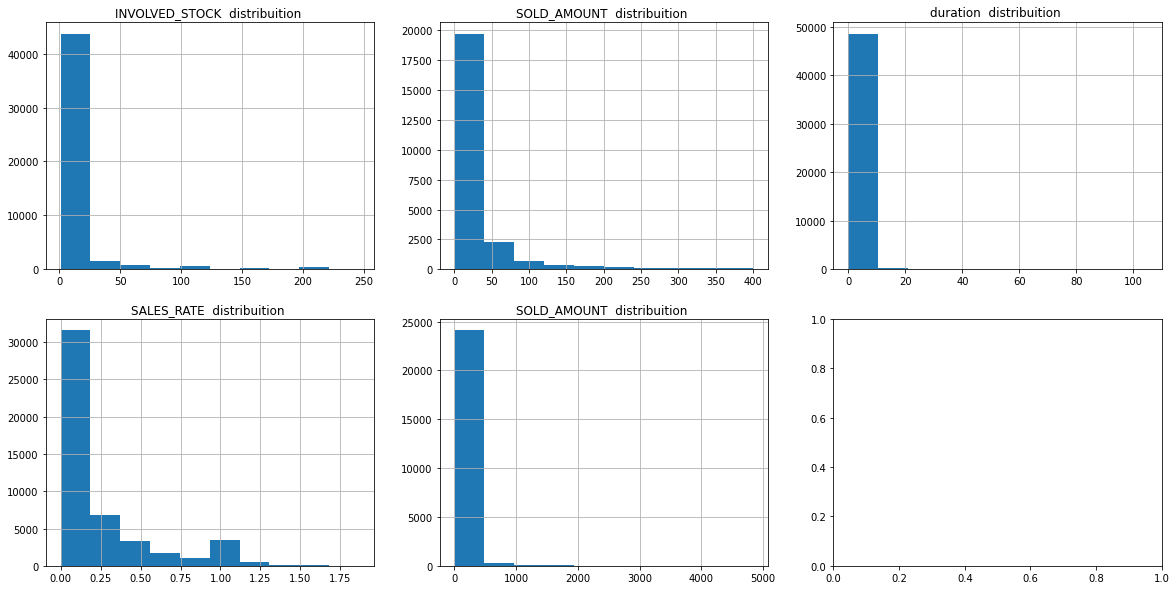

In [45]:
# distruibuição dos valores numéricos
import matplotlib.pyplot as plt
campos = [['INVOLVED_STOCK', 250] , ['SOLD_AMOUNT', 400], 
          ['duration', 50000], ['SALES_RATE', 2], ['SOLD_AMOUNT', 5000000] ]


fig, axos = plt.subplots(2, 3, figsize=(20,10))
axs = axos.flat
    
for i, campo in enumerate(campos):
    
    dtfiltered = dtrelampago[dtrelampago[campo[0]] <  campo[1]] # filters outliers
    Dt_DOMAIN_ID = dtfiltered[campo[0]].hist(ax=axs[i])
    axs[i].title.set_text('{}  distribuition '.format(campo[0]  ))

    

In [230]:
dtrelampago[dtrelampago['SALES_RATE']  > 0.5].shape[0] /dtrelampago.shape[0]

0.15123292167562466

##  Observações da exploração de dados 
  1. OFFER_TYPE,ORIGIN , SHIPPING_PAYMENT_TYPE possuem alguns valores nulos, contudo como possuem apenas um valor possível, não será feito nenhum tratamento e nenhuma análise por hora.
  3. A primeira vista, as ofertas são distribuídas pelos dias da semana sem nenhum padrão claro ou preferência. 
  4. Apenas 15 % das ofertas vendem mais do que 50% do estoque planejado. 
  6. "HOME & INDUSTRY" e "APP & SPORTS" são as caterias "VERTICAL" com mais promoções.
  7. "APPAREL ACCESORIES" e "HOME&DECOR" são as categorias "DOM_DOMAIN_AGG1" com mais promoções. 
   

# 2. Insights gerais  

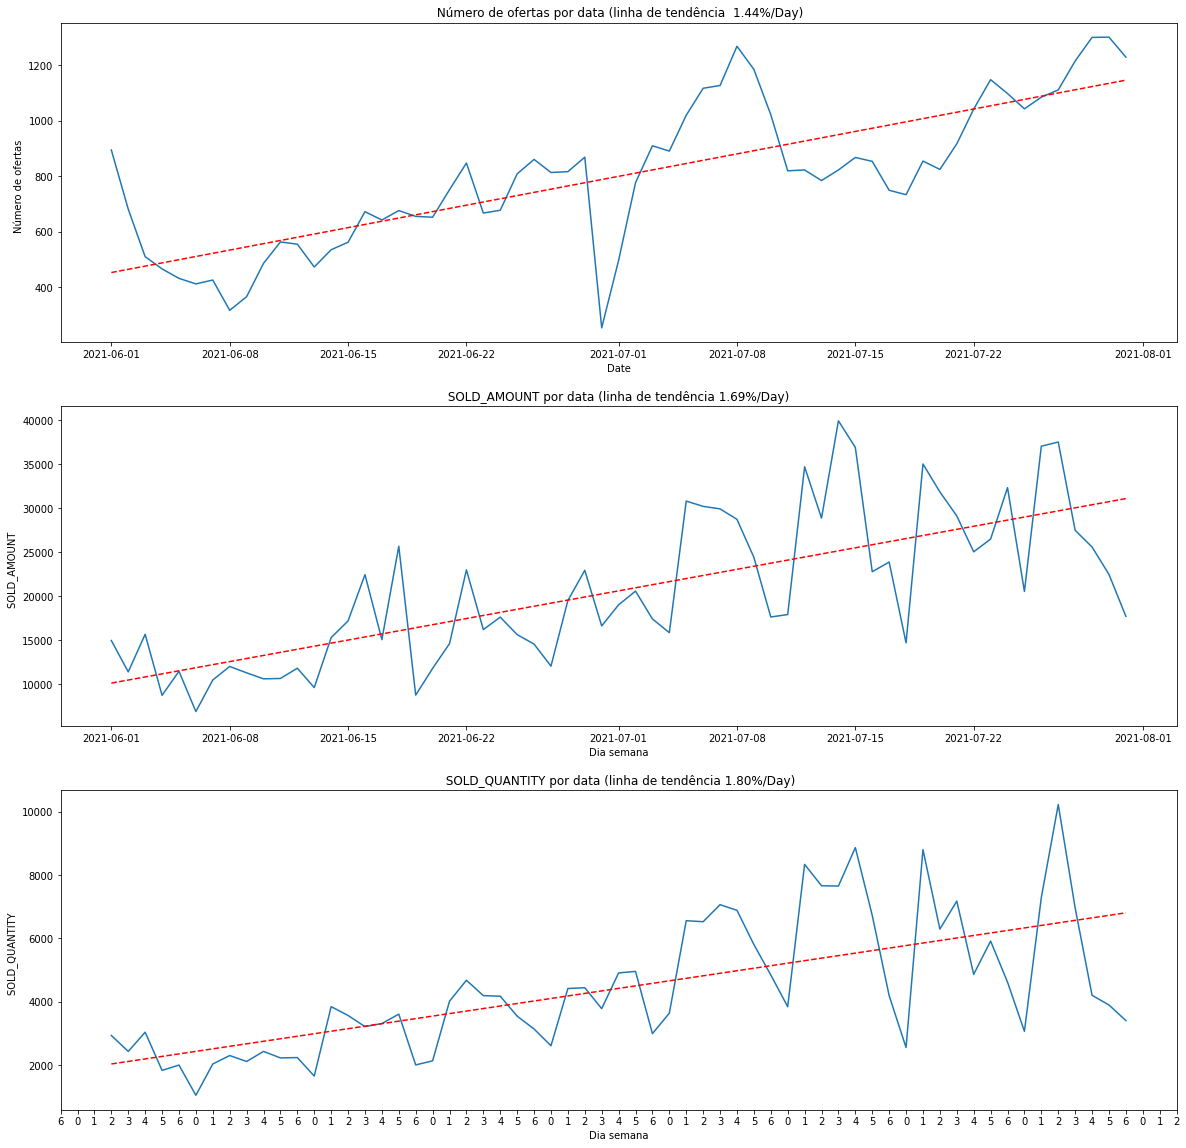

In [46]:

def getTendencia(dtserie):
    x = list(range( dtserie.shape[0]))
    z = np.polyfit(x, dtserie.values, 1)
    p = np.poly1d(z)
    return p(x), z[0]

fig, (ax, ax2, ax3) = plt.subplots(3, figsize=(20,20))

dtrelampago_date = dtrelampago.groupby(['OFFER_START_DATE'])['OFFER_START_DATE'].count()
ax.plot(dtrelampago_date.index , dtrelampago_date.values)
p, trend = getTendencia(dtrelampago_date)
ax.plot(dtrelampago_date.index,p ,"r--")

tilulo = " Número de ofertas por data (linha de tendência  {:.2f}%/Day)".format(trend/(dtrelampago_date.values.mean() /100))

ax.set(xlabel='Date', ylabel='Número de ofertas  ',
       title=tilulo)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  

### SOLD_AMOUNT
dtrelampago_amount = dtrelampago.groupby(['OFFER_START_DATE'])['SOLD_AMOUNT'].sum()
ax2.plot(dtrelampago_amount.index , dtrelampago_amount.values)
p, trend = getTendencia(dtrelampago_amount)
ax2.plot(dtrelampago_amount.index,p ,"r--")

tilulo = " SOLD_AMOUNT por data (linha de tendência {:.2f}%/Day) ".format(trend/(dtrelampago_amount.values.mean() /100))



ax2.set(xlabel='Dia semana', ylabel='SOLD_AMOUNT  ',
       title=tilulo)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('(%w)'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  


### SOLD_QUANTITY
dtrelampago_qt = dtrelampago.groupby(['OFFER_START_DATE'])['SOLD_QUANTITY'].sum()
ax3.plot(dtrelampago_qt.index , dtrelampago_qt.values)

p, trend = getTendencia(dtrelampago_qt)
ax3.plot(dtrelampago_qt.index,p ,"r--")

tilulo = " SOLD_QUANTITY por data (linha de tendência {:.2f}%/Day)".format(trend/(dtrelampago_qt.values.mean() /100))


ax3.set(xlabel='Dia semana', ylabel='SOLD_QUANTITY  ',
       title=tilulo)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%w'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  



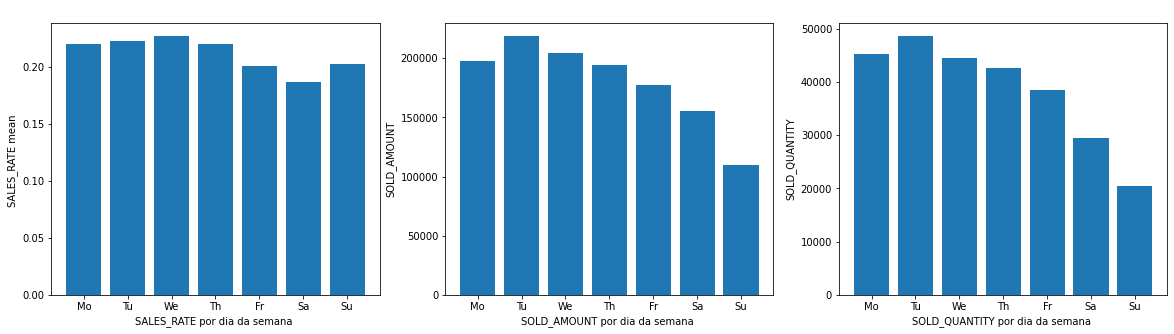

In [49]:
def weekdays(weekday):
    days = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa',
            'Su']
    return days[weekday]
    

campo = 'WEEKDAY'
camposcomp =['SALES_RATE', 'SOLD_AMOUNT', 'SOLD_QUANTITY']


fig, axs = plt.subplots(1,3, figsize=(20,5))
x= [weekdays(w) for w in [0,1,2,3,4,5,6]]

for i, campocomp in enumerate(camposcomp): 

    if i ==0:
        dtgroup = dtrelampago.groupby([campo])[campocomp].mean()
        ylabel = campocomp + " mean "
    else:
        dtgroup = dtrelampago.groupby([campo])[campocomp].sum()
        ylabel = campocomp 
    y = dtgroup.values
    axs[i].bar(x, y)
    tilulo = " "
    axs[i].set(xlabel=campocomp + ' por dia da semana ', ylabel=ylabel  ,
       title=tilulo)


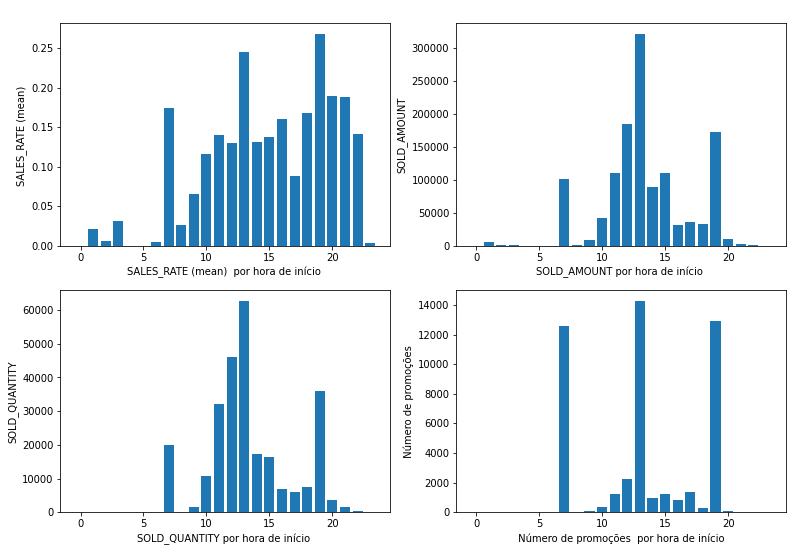

In [53]:

campo = 'START_HOUR'
camposcomp =['SALES_RATE', 'SOLD_AMOUNT', 'SOLD_QUANTITY', 'START_HOUR']


fig, axs = plt.subplots(2,2, figsize=(13,9))

axs = axs.flat
for i, campocomp in enumerate(camposcomp): 

    if i ==0:
        dtgroup = dtrelampago.groupby([campo])[campocomp].mean()
        ylabel = campocomp + " (mean) "
    elif i ==3:
        dtgroup = dtrelampago.groupby([campo])[campocomp].count()
        ylabel =  " Número de promoções "

    else:
        dtgroup = dtrelampago.groupby([campo])[campocomp].sum()
        ylabel = campocomp 
    x = dtgroup.index
    y = dtgroup.values
    axs[i].bar(x, y)
    tilulo = " "
    axs[i].set(xlabel=ylabel + ' por hora de início ', ylabel=ylabel  ,
       title=tilulo)


#  Insights Gerais 
1. Vemos dois picos nas vendas em 7 julho e 30 de julho um mínimo em 30 de junho, aparentemente não são datas especiais mas é  algo que pode-se investigar mais. 
3.**12 de junho é o dia dos namorados no Brasil, onde é possível ver um aumento nas vendas em quantidade e montante, contudo não vemos nenhum movimento especial na quantidade de ofertas o que sugere que o evento poderia ser melhor explorado.**
4.**Em relação a "AMOUNT" e "QUANTITY" das vendas e número de promoções sábado (5) e domingo (6)  são claramente  os piores dias para vender.**
5. O número de promoção têm uma tendência de alta de  +1,4%/dia , "QUANTITY"  +1,7%/dia   and "AMOUNT" +1,8%/dia.
6.**Em relação "AMOUNT" and "QUANTITY"  as vendas das promoções que iniciam  13:00 e 19:00 apresentão melhor performance, o que já é aparentemente conhecido pelos promotores que iniciam suas campanhas prioritariamente neste período, contudo vemos um grande número de promoções iniciando as 8:00 onde não vemos grande performance nas vendas. **

## VERTIAL category  

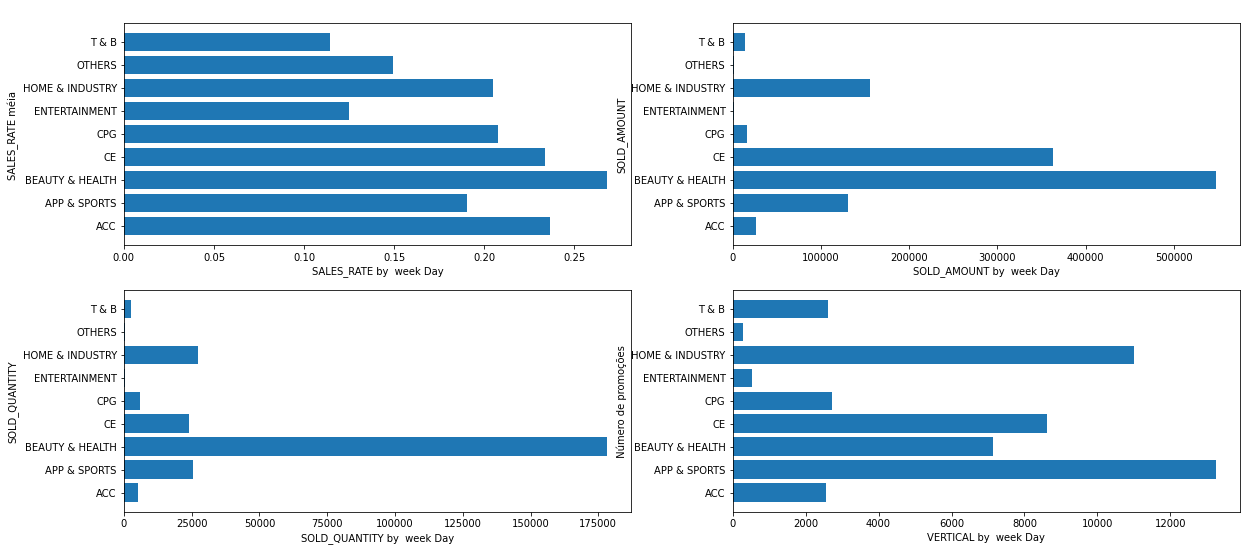

In [20]:

campo = 'VERTICAL'
camposcomp =['SALES_RATE', 'SOLD_AMOUNT', 'SOLD_QUANTITY', 'VERTICAL']


fig, axs = plt.subplots(2,2, figsize=(20,9))

axs = axs.flat
for i, campocomp in enumerate(camposcomp): 

    if i ==0:
        dtgroup = dtrelampago.groupby([campo])[campocomp].mean()
        ylabel = campocomp + " méia "
    elif i ==3:
        dtgroup = dtrelampago.groupby([campo])[campocomp].count()
        ylabel =  " Número de promoções "

    else:
        dtgroup = dtrelampago.groupby([campo])[campocomp].sum()
        ylabel = campocomp 
    x = dtgroup.index
    y = dtgroup.values
    axs[i].barh(x, y)
    tilulo = " "
    axs[i].set(xlabel=campocomp + ' by  week Day', ylabel=ylabel  ,
       title=tilulo)


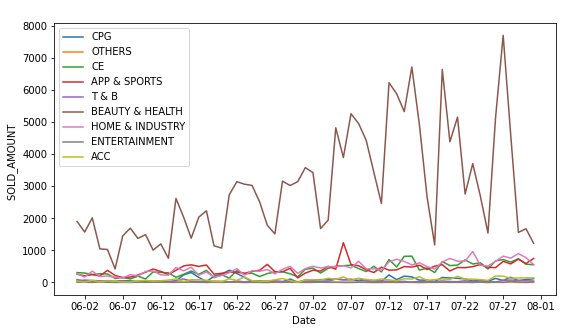

[Text(0, 0.5, 'Categoria '),
 Text(0.5, 0, 'tendência %/day '),
 Text(0.5, 1.0, 'SOLD_AMOUNT growth trend by VERTICAL Catagorical ')]

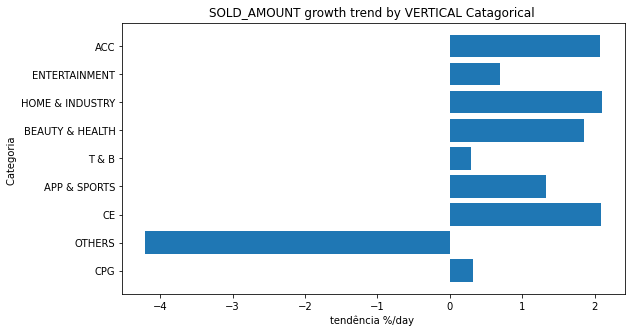

In [61]:
VERTICALS = list(dtrelampago['VERTICAL'].unique())
fig, ax = plt.subplots(1, figsize=(9,5))

trensd = []
besttimes = []
worstdays = []
# now customize the labels
for VERTICAL in  VERTICALS:
    dtrelampagof =dtrelampago[dtrelampago['VERTICAL'] ==VERTICAL]
    # best time
    dtgroup = dtrelampagof.groupby(['START_HOUR'])['SOLD_AMOUNT'].sum()
    besttimes.append(dtgroup.index[dtgroup.argmax()])
    # best time
    dtgroup = dtrelampagof.groupby(['WEEKDAY'])['SOLD_AMOUNT'].sum()
    worstdays.append(dtgroup.index[dtgroup.argmin()])
    
    #
    dtrelampago_qt = dtrelampagof.groupby(['OFFER_START_DATE'])['SOLD_QUANTITY'].sum()
    label = VERTICAL
    p, trend = getTendencia(dtrelampago_qt)
    trend = trend/(dtrelampago_qt.values.mean() /100)
    trensd.append(trend)
    ax.plot(dtrelampago_qt.index , dtrelampago_qt.values, label = label)
    ax.set(xlabel='Date ', ylabel='SOLD_AMOUNT  ',       title=tilulo)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  
ax.legend()
plt.show()
fig, ax = plt.subplots(1, figsize=(9,5))
ax.barh(VERTICALS, trensd)
ax.set(xlabel='tendência %/day ', ylabel='Categoria ',       title="SOLD_AMOUNT growth trend by VERTICAL Catagorical ")

In [63]:
 #VERTICALS 

In [59]:
#  Show the categoricals that presentes a diferent  parther  in relation of best times and worst day to sales
for i,  besttime in  enumerate (besttimes) :
    if besttime not in [13, 19] :
        print("The best time to sale {} is {}:00  ".format(VERTICALS[i], besttime ))

for i,  worstday in  enumerate (worstdays) :
    if worstday not in [5, 6] :
        print("The worst weekday to sale {} is {}  ".format(VERTICALS[i], weekdays(worstday) ))



The best time to sale BEAUTY & HEALTH is 12:00  
The worst weekday to sale APP & SPORTS is Mo  


# Insights em relação a categoria "Vertical" 
1. ***BEAUTY & HEALTH é a categoria com maior volume de vendas "SOLD_AMOUNT" e apresenta um tendecia de crescimento consistente, contudo e  diferentemente do padrão geral o maior volume de vendas desta categoria são nas promoções que iniciaram as 12:00.***
2. A maior parte das categorias apresentaram uma tendência de alta no número de promoção, número de vendas e volume financeiro com destaques positivos para 'ACC', 'CE' e 'HOME & INDUSTRY', somente a categoria "OTHERS" possui tendência de baixa.
3. Em geral sábado e domingo são os piores dias para iniciar uma campanha em relação à performance com execeção os produtos da categoria "APP & SPORTS" onde o pior dia é segunda.

 ## DOM_DOMAIN_AGG1 category 

[Text(0, 0.5, 'DOM_DOMAIN_AGG1'),
 Text(0.5, 0, 'SOLD_AMOUNT '),
 Text(0.5, 1.0, 'Volume de vendas por DOM_DOMAIN_AGG1 ')]

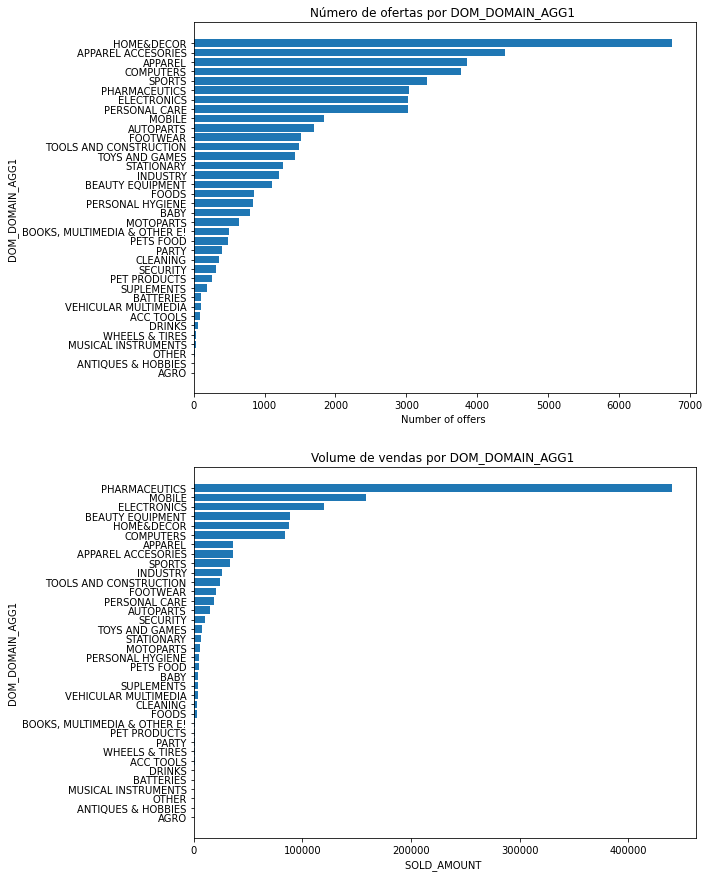

In [23]:
DOM_DOMAIN_AGG1_grop =  dtrelampago.groupby(['DOM_DOMAIN_AGG1'])['DOM_DOMAIN_AGG1'].count()
DOM_DOMAIN_AGG1_grop =DOM_DOMAIN_AGG1_grop.sort_values()
fig, (ax, ax2) = plt.subplots(2, figsize=(9,15))
ax.barh(DOM_DOMAIN_AGG1_grop.index, DOM_DOMAIN_AGG1_grop.values)
DOM_DOMAIN_AGG1_grop =  dtrelampago.groupby(['DOM_DOMAIN_AGG1'])['SOLD_AMOUNT'].sum()
DOM_DOMAIN_AGG1_grop =DOM_DOMAIN_AGG1_grop.sort_values()
ax.set(xlabel='Number of offers ', ylabel='DOM_DOMAIN_AGG1',       title="Número de ofertas por DOM_DOMAIN_AGG1 ")

DOM_DOMAIN_AGG1_grop =DOM_DOMAIN_AGG1_grop.sort_values()
ax2.barh(DOM_DOMAIN_AGG1_grop.index, DOM_DOMAIN_AGG1_grop.values)
ax2.set(xlabel='SOLD_AMOUNT ', ylabel='DOM_DOMAIN_AGG1',       title="Volume de vendas por DOM_DOMAIN_AGG1 ")

In [25]:
percentofsales = DOM_DOMAIN_AGG1_grop.tail(6).sum() /DOM_DOMAIN_AGG1_grop.sum()
print("6 categorias de DOM_DOMAIN_AGG1 representam {:.1f} % do voluem de vendas (SOLD_AMOUNT )".format(percentofsales * 100))
DOM_DOMAIN_AGG1s= list(DOM_DOMAIN_AGG1_grop.tail(6).index)
    

6 categorias de DOM_DOMAIN_AGG1 representam 77.8 % do voluem de vendas (SOLD_AMOUNT )


In [30]:
DOM_DOMAIN_AGG1_grop.tail(6)

DOM_DOMAIN_AGG1
COMPUTERS            83941.78
HOME&DECOR           87761.65
BEAUTY EQUIPMENT     88830.25
ELECTRONICS         119853.95
MOBILE              158992.21
PHARMACEUTICS       440216.74
Name: SOLD_AMOUNT, dtype: float64

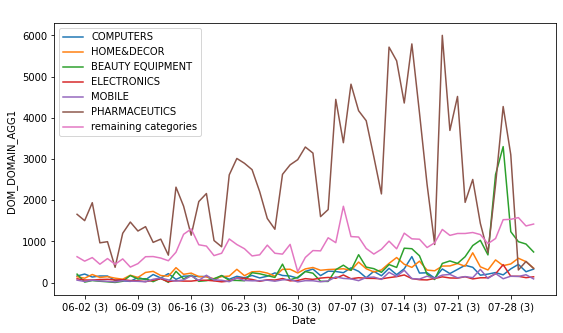

[Text(0, 0.5, ' Categoria DOM_DOMAIN_AGG1 %/day '),
 Text(0.5, 0, 'Tendência de crescimento %/day  '),
 Text(0.5, 1.0, 'Tendência de crescimento de volumende venda "SOLD_AMOUNT" pelas categirs DOM_DOMAIN_AGG1 mais relevantes')]

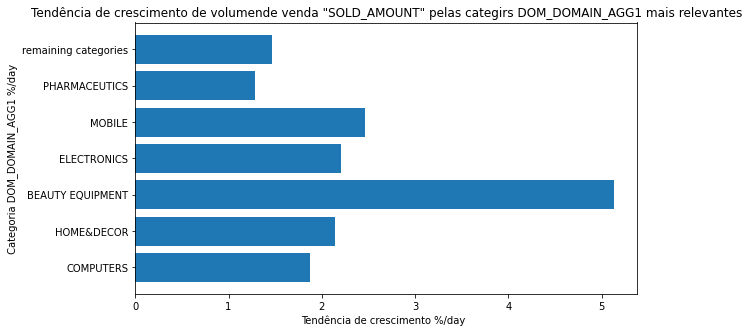

In [60]:

DOM_DOMAIN_AGG1s = list(DOM_DOMAIN_AGG1_grop.tail(6).index)
DOM_DOMAIN_AGG1s.append("remaining categories")

fig, ax = plt.subplots(1, figsize=(9,5))

trensd = []
besttimes = []
worstdays = []
# now customize the labels
for DOM_DOMAIN_AGG1 in  DOM_DOMAIN_AGG1s:
    if DOM_DOMAIN_AGG1 == "remaining categories" :
        dtrelampagof =dtrelampago[dtrelampago['DOM_DOMAIN_AGG1'].isin(DOM_DOMAIN_AGG1s) == False]
    else:     
        dtrelampagof =dtrelampago[dtrelampago['DOM_DOMAIN_AGG1'] ==DOM_DOMAIN_AGG1]
        
    # best time
    dtgroup = dtrelampagof.groupby(['START_HOUR'])['SOLD_AMOUNT'].sum()
    besttimes.append(dtgroup.index[dtgroup.argmax()])
    # best time
    dtgroup = dtrelampagof.groupby(['WEEKDAY'])['SOLD_AMOUNT'].sum()
    worstdays.append(dtgroup.index[dtgroup.argmin()])
    
    #
    dtrelampago_qt = dtrelampagof.groupby(['OFFER_START_DATE'])['SOLD_QUANTITY'].sum()
    label = DOM_DOMAIN_AGG1
    p, trend = getTendencia(dtrelampago_qt)
    trend = trend/(dtrelampago_qt.values.mean() /100)
    trensd.append(trend)
    ax.plot(dtrelampago_qt.index , dtrelampago_qt.values, label = label)
    ax.set(xlabel='Date ', ylabel='DOM_DOMAIN_AGG1  ',       title=tilulo)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d (%w)'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  
ax.legend()
plt.show()
fig, ax = plt.subplots(1, figsize=(9,5))
ax.barh(DOM_DOMAIN_AGG1s, trensd)
ax.set(xlabel='Tendência de crescimento %/day  ', ylabel=' Categoria DOM_DOMAIN_AGG1 %/day ',       title='Tendência de crescimento de volumende venda "SOLD_AMOUNT" pelas categirs DOM_DOMAIN_AGG1 mais relevantes')

# Insights em relação a categoria "DOM_DOMAIN_AGG1" 
1. ***6 categorias de DOM_DOMAIN_AGG1 representam 77.8 % do volume de vendas (SOLD_AMOUNT ) ***
2. A categoria PHARMACEUTICS possui o maior volume de vendas e apresenta um tendência de crescimento consistente contudo abaixo da média. 
3. Entre as 6 categoriaa de maior volume "BEAUTY EQUIPMENT" é a que tem maior tendência de cresciemto no volume de vendas, crescendo a uma taxa de  5% ao dia.  

# VERTIAL DOMAIN_ID

Total DOMAIN_ID 1266 total vendas 1258663.4999999993  


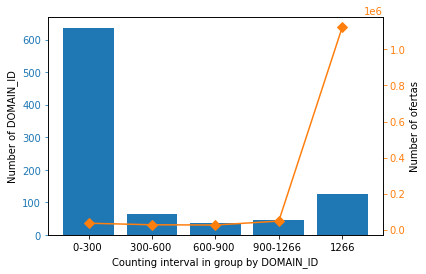

In [31]:
dtDOMAIN_ID_group =  dtrelampago.groupby(['DOMAIN_ID'])['SOLD_AMOUNT'].sum()
#dtDOMAIN_ID_group[dtDOMAIN_ID_group.values   < 50 ].hist(bins=50)


intervalos = [0, 300, 600,  900, 1266  ]

results =[]
for i in range(len(intervalos)):
    if i +1 < len(intervalos): 
        dffilter =   dtDOMAIN_ID_group[(dtDOMAIN_ID_group.values   > intervalos[i]) & (dtDOMAIN_ID_group.values   < intervalos[i +1] )]
        label = "{}-{} ".format(intervalos[i], intervalos[i +1])
    else:     
        dffilter =   dtDOMAIN_ID_group[dtDOMAIN_ID_group.values   > intervalos[i] ]
        label = "{}".format(intervalos[i])
        
    results.append([label, dffilter.sum() , dffilter.count()])
    
    
print("Total DOMAIN_ID {} total vendas {}  ".format(dtDOMAIN_ID_group.count() , dtDOMAIN_ID_group.sum()) )    

df = pd.DataFrame (results, columns = ['Range count DOMAIN_ID', 'N. ofertas', 'N. DOMAIN_ID'])

fig, ax = plt.subplots()
ax.bar(df["Range count DOMAIN_ID"], df["N. DOMAIN_ID"], color="C0")

ax.set_ylabel('Number of DOMAIN_ID')
ax.set_xlabel('Counting interval in group by DOMAIN_ID')
ax2 = ax.twinx()
ax2.plot(df.index, df["N. ofertas"], color="C1", marker="D", ms=7)
#ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax2.set_ylabel('Number of ofertas')
plt.show()

In [32]:
dffiltered =  dtDOMAIN_ID_group.sort_values().tail(int(dtDOMAIN_ID_group.shape[0]/10))

print("Total DOMAIN_ID {} total vendas {}  ".format(dtDOMAIN_ID_group.count() , dtDOMAIN_ID_group.sum()) )    
print("Os 10 % ID_group  mais frequentes em promoções são reponsaveis {:.1f} % do número de promoções ".format(100 *dffiltered.sum()  / dtDOMAIN_ID_group.sum()) )    

Total DOMAIN_ID 1266 total vendas 1258663.4999999993  
Os 10 % ID_group  mais frequentes em promoções são reponsaveis 89.1 % do número de promoções 


In [292]:
dtrelampago[dtrelampago['SALES_RATE']  > 0.5].shape[0] /dtrelampago.shape[0]

0.15123292167562466

##  Insights mais significativos (Resumo)
####Em relação "AMOUNT" and "QUANTITY"  as vendas das promoções que iniciam  13:00 e 19:00 apresentão melhor performance, o que já é aparentemente conhecido pelos promotores que iniciam suas campanhas prioritariamente neste período, contudo vemos um grande número de promoções iniciando as 8:00 onde não vemos grande performance nas vendas. 
####  2. Outro padrão em relação ao número e volume de vendas é em relação ao dia da promoção, os piores dias de vendas costumam ser sábado (5) e domingo (6), com exeção os itens da categoria "APP & SPORTS" que é segunda .
####  3. 12 de junho é o dia dos namorados no Brasil, onde é possível ver uma alta nas vendas em quantidade "QUANTITY" e montante "AMOUNT, contudo não vemos nenhum movimento especial na quantidade de ofertas o que sugere que o evento poderia ser melhor explorado.
####  4.  O volume de vendas "AMOUNT",  número de campanha e quantidade de vendas QUANTITY" estão claramente com tendência de alta e olhando para as  catagorias verticais temos como destaques  positivos para  'ACC', 'CE' e 'HOME & INDUSTRY' , somente a categoria "OTHERS" possui tendência de baixa.
####   5. Os 10 % ID_group  mais frequentes em promoções são reponsaveis 89.1 % do número de promoções 


